# Capstone Project: The Battle of the Neighbourhoods [London Edition]

#### Coursera: Applied Data Science Capstone


## 1. Introduction

In this project, we will try to identify the best neighbourhood in London for a family to buy their first home, based on their existing preferences about London neighbourhoods and the budget they have available.

London is a large cosmopolitan city with a population of nearly 9 million. There are a number of distinct neighbourhoods in London, each with its own feel and characteristics. 

Buying a house in London can be challenging, because of high prices and high demand for houses in nice neighbourhoods with good transport connections. We will model a hypothetical family who is currently renting a house in Balham, South London. They'd like to buy their own place in their current neighbourhood, but are unable to because of the high prices. We will use data from the Foursquare API and the K-Means clustering algorithm to identify neighbourhoods that are most similar to where they currently live, but where house prices are lower.

The output will be a shortlist of neighbourhoods where the family should consider purchasing a home. Individuals and families who are looking to buy a home in London would be interested in this output.


## 2. Data
Based on the problem defined above, relevant data for our analysis are as follows:

- **House prices by neighbourhood.** We will define neighbourhood as London Electoral Wards. Wards are a useful way to think of neighbourhoods as there is readily available house price data at the Ward level. This data will provide median house prices for each ward in London and can be sourced from the Office for National Statistics (ONS): https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbywardhpssadataset37
- **List of neighbourhoods within London.** This will provide the full list of candidate neighbourhoods. This data is hosted at https://data.london.gov.uk/
- **Latitude / longitude data.** The geographical center of each neighbourhood / ward will be generated from the Ward name using Nominatim.
- **Information about the amenities in each neighbourhood.** We will use the Foursquare API to generate a list of the most popular points of interest for each neighbourhood, based on the latitude / longitude data described above. Points of interest returned by the Foursquare API will include retaurants, bars, parks, shops, etc.

To answer the question about where the hypothetical family should consider buying a home, we will:

- Download the house price data for each ward in London
- Use Nominatim to calculate the geographical centre of each ward
- Use the coordinates generated and the Foursquare API to learn about the amenities in each ward
- Use K-Means to cluster the wards
- Identify suitable wards for the family to consider living in, based on similarities to Balham
- Rank these neighbourhoods in order of affordability

## 3. Methodology

### Import relevant libraries

We start by importing the Python libraries that we will need for this analysis:

- **pandas and numpy** to help manage and wrangle data
- **Nominatim** to allow us to gather lat and long data from a street address
- **folium** to allow creating maps
- **json, requests and json_normalize** to allow us to gather data from the Foursquare API
- **KMeans** to allow us to run K-means clustering

In [456]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import json
import requests
from pandas import json_normalize
from sklearn.cluster import KMeans 
import numpy as np

### Wrangle the data

#### Load and clean datasets

We start by loading UK house price data (that was previously downloaded from the Office for National Statistics at https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbywardhpssadataset37). 
This is a big file, so it may take some time!

In [3]:
data = pd.read_excel('ONS - house price data.xls', sheet_name = '1a', skiprows = 5, index_col = 2)
data.dropna(subset = ['Ward name'], inplace = True, axis = 0)
data.head()

,Local authority code,Local authority name,Ward name,Year ending Dec 1995,Year ending Mar 1996,Year ending Jun 1996,Year ending Sep 1996,Year ending Dec 1996,Year ending Mar 1997,Year ending Jun 1997,...,Year ending Sep 2018,Year ending Dec 2018,Year ending Mar 2019,Year ending Jun 2019,Year ending Sep 2019,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104
Ward code,,,,,,,,,,,,,,,,,,,,,
E05008942,E06000001,Hartlepool,Burn Valley,29750,29850,30000,30000,30250,30000,30250,...,83500,83000,95000,99000,101000,NaN,NaN,NaN,NaN,NaN
E05008943,E06000001,Hartlepool,De Bruce,38000,38000,37000,30500,30000,30500,29500,...,124950,121375,128000,135000,131475,NaN,NaN,NaN,NaN,NaN
E05008944,E06000001,Hartlepool,Fens and Rossmere,51000,51000,50000,47975,47500,47500,47000,...,130000,128500,125000,126750,127000,NaN,NaN,NaN,NaN,NaN
E05008945,E06000001,Hartlepool,Foggy Furze,39000,39000,39000,38625,38250,38250,38750,...,102000,95000,99000,102000,102500,NaN,NaN,NaN,NaN,NaN
E05008946,E06000001,Hartlepool,Hart,56500,56500,56500,56950,58425,59950,63000,...,152000,155000,150000,145000,148000,NaN,NaN,NaN,NaN,NaN


Exclude columns that aren't relevant. For this analysis we're only interested in the most recent data on house prices which is from Sep 2019.

In [458]:
prices = data[['Ward name', 'Year ending Sep 2019']].copy()
prices.rename(columns = {'Year ending Sep 2019': 'Median house price'}, inplace = True)

We now download the list of London Wards only as this is where we will focus our analysis. This data can be found at the London Datastore at https://data.london.gov.uk

In [5]:
london_url = 'https://data.london.gov.uk/download/excel-mapping-template-for-london-boroughs-and-wards/41ef01e0-2c93-4aea-9c99-f0a7258ef988/Mapping-template-london-ward-map-2018.xls'
london_wards = pd.read_excel(london_url, usecols = [0,1,2], index_col = 0)
london_wards.dropna(inplace = True)
london_wards

,Ward name,Borough name
Code,,
E05000026,Abbey,Barking and Dagenham
E05000027,Alibon,Barking and Dagenham
E05000028,Becontree,Barking and Dagenham
E05000029,Chadwell Heath,Barking and Dagenham
E05000030,Eastbrook,Barking and Dagenham
...,...,...
E05000645,Tachbrook,Westminster
E05000646,Vincent Square,Westminster
E05000647,Warwick,Westminster


Next, we combine the two dataframes using the ward code that is the index for each dataframe. This results in a dataset of London wards and the median house price for houses sold in the 12 months to September 2019

In [6]:
df = london_wards.merge(prices['Median house price'], left_index = True, right_index = True)
df.head()

,Ward name,Borough name,Median house price
E05000026,Abbey,Barking and Dagenham,220000
E05000027,Alibon,Barking and Dagenham,310000
E05000028,Becontree,Barking and Dagenham,307500
E05000029,Chadwell Heath,Barking and Dagenham,359000
E05000030,Eastbrook,Barking and Dagenham,338000


We check the data types of the different columns using dtypes

In [7]:
df.dtypes

Ward name             object
Borough name          object
Median house price    object
dtype: object

We want 'Median house price' to be a float for our analysis, so we convert this. We also divide it by 1,000 to give house prices in £'000s

In [8]:
df['Median house price'] = df['Median house price'].astype(float)/1000
df.dtypes

Ward name              object
Borough name           object
Median house price    float64
dtype: object

#### Collect latitude and longitude data for each neighbourhood

We use Nominatim to load latitude and longitude for each of the ~600 neighbourhoods (wards) in the dataset. We know some of these will fail as the ward name does not align with a street address; for these we define the latitude and longitude as 'Unknown' so we can can explore them further, or remove them, later.

In [106]:
geolocator = Nominatim(user_agent="explorer")

loc = pd.DataFrame(columns = ['code','ward','borough','address','lat','lng'])

for code, ward, borough in zip(df.index, df['Ward name'], df['Borough name']):
    address = (ward+', '+borough+', London, UK')
        
    try:
        location = geolocator.geocode(address)    
        latitude = location.latitude
        longitude = location.longitude
    
    except:
        latitude = 'Unknown'
        longitude = 'Unknown'
        
    loc = loc.append({'code': code, 'ward': ward, 'borough': borough, 'address': address, 'lat': latitude, 'lng': longitude}, ignore_index = True)
  
    print(address+' - '+str(latitude)+', '+str(longitude))

loc.tail()

loc.set_index('code', drop = True, inplace = True)

Abbey, Barking and Dagenham, London, UK - 51.5356876, 0.07553043645175103
Alibon, Barking and Dagenham, London, UK - 51.5482797, 0.153244
Becontree, Barking and Dagenham, London, UK - 51.5403111, 0.1265241
Chadwell Heath, Barking and Dagenham, London, UK - 51.5679857, 0.127994
Eastbrook, Barking and Dagenham, London, UK - 51.5515648, 0.16154306778846314
Eastbury, Barking and Dagenham, London, UK - 51.5344736, 0.0993936
Gascoigne, Barking and Dagenham, London, UK - 51.5322827, 0.0812505
Goresbrook, Barking and Dagenham, London, UK - 51.5355397, 0.1414408666617633
Heath, Barking and Dagenham, London, UK - 51.5679857, 0.127994
Longbridge, Barking and Dagenham, London, UK - 51.5410458, 0.0836358
Mayesbrook, Barking and Dagenham, London, UK - 51.5483331, 0.1107966346709997
Parsloes, Barking and Dagenham, London, UK - 51.544383249999996, 0.13441881353302945
River, Barking and Dagenham, London, UK - 51.5541171, 0.15050434261994267
Thames, Barking and Dagenham, London, UK - 51.5286041, 0.10436

Selhurst, Croydon, London, UK - 51.3922136, -0.0886537
Thornton Heath, Croydon, London, UK - 51.3988709, -0.099602
New Addington South, Croydon, London, UK - 51.3426434, -0.0174858
Broad Green, Croydon, London, UK - 51.3833946, -0.1083305
Waddon, Croydon, London, UK - 51.3673011, -0.1173627
Shirley South, Croydon, London, UK - 51.3749243, -0.0466335
Selsdon & Addington Village, Croydon, London, UK - 51.3527105, -0.04061770834441669
South Norwood, Croydon, London, UK - 51.3980951, -0.0768216
Kenley, Croydon, London, UK - 51.3227524, -0.1037854
Old Coulsdon, Croydon, London, UK - 51.307089, -0.119647
Crystal Palace & Upper Norwood, Croydon, London, UK - Unknown, Unknown
Acton Central, Ealing, London, UK - 51.5087164, -0.2628073
Cleveland, Ealing, London, UK - 51.52300205, -0.32242356433147457
Dormers Wells, Ealing, London, UK - 51.5184396, -0.3665521312181104
Ealing Broadway, Ealing, London, UK - 51.5149803, -0.3004067
Ealing Common, Ealing, London, UK - 51.5097107, -0.2881658
East Acton

Edgware, Harrow, London, UK - 51.6188193, -0.2886172396474118
Greenhill, Harrow, London, UK - 51.5840017, -0.3330006
Harrow On The Hill, Harrow, London, UK - 51.5792702, -0.3366561
Harrow Weald, Harrow, London, UK - 51.6047861, -0.3404854
Hatch End, Harrow, London, UK - 51.6095781, -0.3687836
Headstone North, Harrow, London, UK - 51.591883249999995, -0.35421665178460315
Headstone South, Harrow, London, UK - 51.591883249999995, -0.35421665178460315
Kenton East, Harrow, London, UK - 51.581287, -0.31647316158869243
Kenton West, Harrow, London, UK - 51.581287, -0.31647316158869243
Marlborough, Harrow, London, UK - 51.5899659, -0.332507
Pinner, Harrow, London, UK - 51.5968712, -0.3770142
Pinner South, Harrow, London, UK - 51.5968712, -0.3770142
Queensbury, Harrow, London, UK - 51.5948401, -0.2928285
Rayners Lane, Harrow, London, UK - 51.5767143, -0.3703002
Roxbourne, Harrow, London, UK - 51.5654065, -0.3733966
Roxeth, Harrow, London, UK - 51.560482199999996, -0.3500747050918491
Stanmore Par

Tolworth And Hook Rise, Kingston upon Thames, London, UK - 51.3788758, -0.2828604
Tudor, Kingston upon Thames, London, UK - 51.429961, -0.3052083
Bishop's, Lambeth, London, UK - 51.4935902, -0.1097627
Brixton Hill, Lambeth, London, UK - 51.4458757, -0.1242852
Clapham Common, Lambeth, London, UK - 51.4620748, -0.1373589
Clapham Town, Lambeth, London, UK - 51.4622924, -0.1388561
Coldharbour, Lambeth, London, UK - 51.4630202, -0.1075888
Ferndale, Lambeth, London, UK - 51.5013012, -0.117287
Gipsy Hill, Lambeth, London, UK - 51.4247042, -0.0845885
Herne Hill, Lambeth, London, UK - 51.4534691, -0.1022835
Knight's Hill, Lambeth, London, UK - 51.4296577, -0.1042819
Larkhall, Lambeth, London, UK - 51.46804485, -0.1366373978454975
Oval, Lambeth, London, UK - 51.48375215, -0.11496182711601476
Prince's, Lambeth, London, UK - Unknown, Unknown
St. Leonard's, Lambeth, London, UK - 51.42912525, -0.1325481505317565
Stockwell, Lambeth, London, UK - 51.472211, -0.1225014
Streatham Hill, Lambeth, London, 

Newington, Southwark, London, UK - 51.4921753, -0.1019873
North Bermondsey, Southwark, London, UK - 51.497826399999994, -0.06579464517704528
North Walworth, Southwark, London, UK - 51.49036395, -0.09047726110254103
Nunhead & Queen's Road, Southwark, London, UK - 51.4690591, -0.0566640271781048
Old Kent Road, Southwark, London, UK - 51.488618, -0.0771496
Peckham, Southwark, London, UK - 51.4734122, -0.0699321
Peckham Rye, Southwark, London, UK - 51.469919, -0.0696968
Rotherhithe, Southwark, London, UK - 51.5007782, -0.0519063
Rye Lane, Southwark, London, UK - 51.4666487, -0.0659249
South Bermondsey, Southwark, London, UK - 51.4879512, -0.0544564
St. George's, Southwark, London, UK - 51.480200749999995, -0.08321835923030207
St. Giles, Southwark, London, UK - 51.4754064, -0.0849728
Surrey Docks, Southwark, London, UK - 51.49307865, -0.04639640518134707
Beddington North, Sutton, London, UK - 51.3719875, -0.1323928
Beddington South, Sutton, London, UK - 51.3719875, -0.1323928
Belmont, Sutto

We save this new dataframe *loc* as a CSV, to save us having to run this process again in the future.

In [108]:
loc.to_csv('london_ward_data.csv')

In the future, we can use the following code to load the latitude and longitude data.

In [12]:
loc = pd.read_csv('london_ward_data.csv')
loc.set_index('code', drop = True, inplace = True)
loc

,ward,borough,address,lat,lng
code,,,,,
E05000026,Abbey,Barking and Dagenham,"Abbey, Barking and Dagenham, London, UK",51.5356876,0.07553043645175103
E05000027,Alibon,Barking and Dagenham,"Alibon, Barking and Dagenham, London, UK",51.5482797,0.153244
E05000028,Becontree,Barking and Dagenham,"Becontree, Barking and Dagenham, London, UK",51.5403111,0.1265241
E05000029,Chadwell Heath,Barking and Dagenham,"Chadwell Heath, Barking and Dagenham, London, UK",51.5679857,0.127994
E05000030,Eastbrook,Barking and Dagenham,"Eastbrook, Barking and Dagenham, London, UK",51.5515648,0.16154306778846314
...,...,...,...,...,...
E05000645,Tachbrook,Westminster,"Tachbrook, Westminster, London, UK",51.4933046,-0.1400497
E05000646,Vincent Square,Westminster,"Vincent Square, Westminster, London, UK",51.4940178,-0.1362304
E05000647,Warwick,Westminster,"Warwick, Westminster, London, UK",51.49240735,-0.13970480261141285


Next, we add the latitude and longitude data to our main dataframe. We now have ward name, median hour price, latitude and longitude, all in one dataframe.

In [13]:
df = df.merge(loc[['lat', 'lng']], left_index = True, right_index = True)
print(df.shape)
df.head()

(632, 5)


,Ward name,Borough name,Median house price,lat,lng
E05000026,Abbey,Barking and Dagenham,220.0,51.5356876,0.07553043645175103
E05000027,Alibon,Barking and Dagenham,310.0,51.5482797,0.153244
E05000028,Becontree,Barking and Dagenham,307.5,51.5403111,0.1265241
E05000029,Chadwell Heath,Barking and Dagenham,359.0,51.5679857,0.127994
E05000030,Eastbrook,Barking and Dagenham,338.0,51.5515648,0.16154306778846314


We know there are some wards where we weren't able to get location data using Nominatim. We can look at which wards these are.

In [14]:
df[df['lat'] == 'Unknown'].count()

Ward name             40
Borough name          40
Median house price    40
lat                   40
lng                   40
dtype: int64

In [15]:
df[df['lat'] == 'Unknown']['Ward name'].to_list()

['Falconwood & Welling',
 'Slade Green & Northend',
 "St. Mary's & St. James",
 'Bromley Common and Keston',
 'Farnborough and Crofton',
 'Kelsey And Eden Park',
 'Mottingham and Chislehurst North',
 'Penge And Cator',
 'Camden Town With Primrose Hill',
 'Frognal And Fitzjohns',
 'St. Pancras And Somers Town',
 'Park Hill & Whitgift',
 'Purley Oaks & Riddlesdown',
 'Crystal Palace & Upper Norwood',
 'Kidbrooke With Hornfair',
 'Middle Park And Sutcliffe',
 'Avonmore And Brook Green',
 'College Park And Old Oak',
 'North End',
 'Mawneys',
 'Heathrow Villages',
 'Chiswick Homefields',
 'Brompton and Hans Town',
 "Prince's",
 'Ham, Petersham and Richmond Riverside',
 'Mortlake and Barnes Common',
 "St. Margaret's and North Twickenham",
 'Sutton South',
 'Blackwall & Cubitt Town',
 "St. Katharine's & Wapping",
 "St. Peter's",
 'Spitalfields & Banglatown',
 'Weavers',
 'Cann Hall',
 'Grove Green',
 'Hale End And Highams Park',
 'Valley',
 'Roehampton And Putney Heath',
 "St. Mary's Park",
 

For now, we will exclude these wards. We have data for nearly 600 wards, and they're not that widely distributed across London, so the loss of ~40 will not be an issue

In [16]:
df.drop(df[df['lat'] == 'Unknown'].index, axis = 0, inplace = True)
df.shape

(592, 5)

### Exploratory analysis of neighbourhood and house price data

We can examine the distribution of house prices in London using a boxplot and histogram

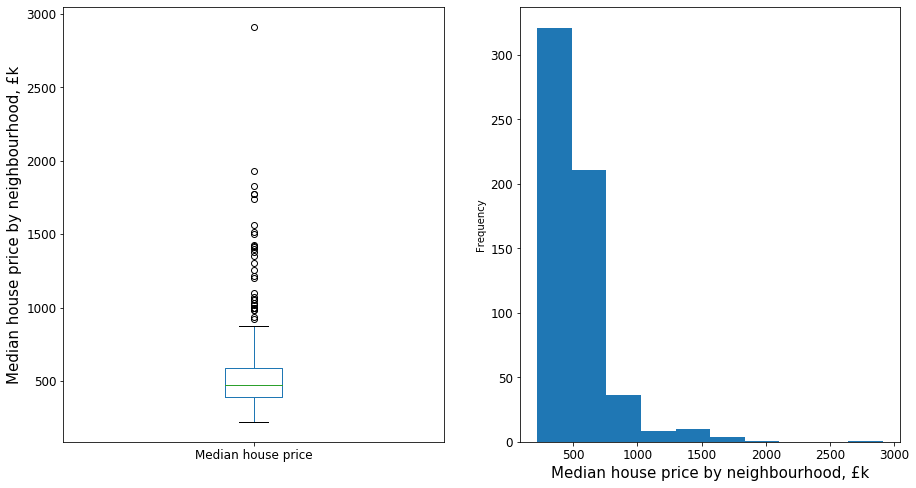

In [499]:
fig = plt.figure()

#Create subplots
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

#Plot 1
df['Median house price'].plot(kind = 'box', figsize = (15,8), fontsize = 12, ax = ax0)
ax0.set_ylabel('Median house price by neighbourhood, £k',fontsize = 15)

#Plot 1
df['Median house price'].plot(kind = 'hist', fontsize = 12, ax = ax1)
ax1.set_xlabel('Median house price by neighbourhood, £k',fontsize = 15)

plt.show()

We can also plot the location of each neighbourhood (ward) using Folium, so we can start to get an understanding of what we're working with.

We start by using Nominatim to get the lat and long for London, so we can centre the map.

In [17]:
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode('London, UK')    
london_lat = location.latitude
london_lng = location.longitude
print("London's lat and long are: ", london_lat, london_lng)

London's lat and long are:  51.5073219 -0.1276474


We then plot the neighbourhood data on a map of London using Folium.

In [18]:
map = folium.Map(location = [london_lat, london_lng], zoom_start = 10)

for name, lat, lng in zip(df.index, df['lat'], df['lng']):
    folium.CircleMarker(location = [lat, lng],
                       radius = 4,
                       icon = None,
                       color = 'blue',
                        fill=True,
                        fill_color='black',
                        fill_opacity=1,
                        popup = name
                       ).add_to(map)

map

However, this map doesn't give us any information about median house price within each neighbourhood.

We can include this information by changing the colour of the marker based on the median house price. We define house prices arbitrarily as follows with colours changing from green to yellow to orange to red to black as house prices increase - i.e.

- Under £400,000 = Very Low (green)
- £400,000-500,000 = Low (yellow)
- £500,000-600,000 = Medium (orange)
- £600,000-1,000,000 = High (red)
- Over £1,000,000 = Very high (black)

In [19]:
df2 = df.copy()

df2.loc[df2['Median house price'] < 400, 'Price category'] = 'green'
df2.loc[(df2['Median house price'] >= 400) & (df2['Median house price'] < 500), 'Price category'] = 'yellow'
df2.loc[(df2['Median house price'] >= 500) & (df2['Median house price'] < 600), 'Price category'] = 'orange'
df2.loc[(df2['Median house price'] >= 600) & (df2['Median house price'] < 1000), 'Price category'] = 'red'
df2.loc[(df2['Median house price'] >= 1000), 'Price category'] = 'black'

df2['Price category'].value_counts()

yellow    187
green     155
orange    121
red       100
black      29
Name: Price category, dtype: int64

In [276]:
map2 = folium.Map(location = [london_lat, london_lng], zoom_start = 10)

for name, lat, lng, colour, price in zip(df2['Ward name'], df2['lat'], df2['lng'], df2['Price category'], df2['Median house price']):
    label = name+': '+str(round(price))+'k'
    folium.CircleMarker(location = [lat, lng],
                       radius = 4,
                       icon = None,
                       color = colour,
                        fill=True,
                        fill_color=colour,
                        fill_opacity=1,
                        popup = label
                       ).add_to(map2)

map2

We can see that there is a general trend for house prices to decrease as we move away from the center of London

### Explore the neighborhoods using the Foursquare API
First, define Foursquare credentials and version

In [277]:
CLIENT_ID = 'LCBA4FF22TQHU5ETZ0GAWTQ4FR01AANEYOOCQM3YTLB0H2E4'
CLIENT_SECRET = 'SRI2BFTOAOGOMPK4LG1U5OE12GXWWBUQRO3C4R42NV1FMP1Q'
VERSION = '20200521'

We're going to explore the top 200 venues in each neighbourhood.

As the neighbourhoods are tightly packed in London, we'll limit the radius to 500 metres

In [461]:
LIMIT = 200
RADIUS = 500

We can start with a test looking at one neighbourhood, Balham (which also happens to be where I live)

In [462]:
ward = 'Balham'


url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&limit={}&ll={},{}&radius={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    LIMIT,
    float(df[df['Ward name'] == ward]['lat']),
    float(df[df['Ward name'] == ward]['lng']),
    RADIUS)

url

'https://api.foursquare.com/v2/venues/explore?client_id=LCBA4FF22TQHU5ETZ0GAWTQ4FR01AANEYOOCQM3YTLB0H2E4&client_secret=SRI2BFTOAOGOMPK4LG1U5OE12GXWWBUQRO3C4R42NV1FMP1Q&v=20200521&limit=200&ll=51.4456449,-0.1503643&radius=500'

In [463]:
results = requests.get(url).json()

#Create the dataframe
venues = results['response']['groups'][0]['items']
venues = json_normalize(venues)
venues = venues.loc[:,['venue.name', 'venue.categories', 'venue.location.distance','venue.location.lat', 'venue.location.lng']]

#Add the categories column
category_list=[]

for i in range(len(venues)):
    category = venues['venue.categories'][i][0]['name']
    category_list.append(category)

venues['category'] = category_list

#Tidy up the columns
venues.drop('venue.categories', inplace = True, axis = 1)
venues.columns = [col.split('.')[-1] for col in venues.columns]

print(venues.shape)
venues.head()

(55, 5)


,name,distance,lat,lng,category
0,We Brought Beer,148,51.444324,-0.150656,Beer Store
1,M1LK,138,51.444450,-0.150913,Coffee Shop
2,Ciullosteria,192,51.447144,-0.148981,Italian Restaurant
3,Brickwood Coffee & Bread,137,51.444509,-0.151127,Coffee Shop
4,Franco Manca,227,51.443616,-0.149959,Pizza Place


We can see that the query returns 55 results for Balham that are outputted as a dataframe.

Now, we repeat this process for all ~600 neighbourhoods. This will take some time as each query will run sequentially.

In [280]:
london_venues = pd.DataFrame(columns = ['venue.name', 'venue.location.distance', 'venue.location.lat', 'venue.location.lng', 'category', 'code','ward'])

for code, ward, lat, lng in zip(df.index, df['Ward name'], df['lat'], df['lng']):

    try:
        #Create the URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&limit={}&ll={},{}&radius={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        LIMIT,
        lat,
        lng,
        RADIUS)

        #Make the request, get the results
        results = requests.get(url).json()

        #Get the relevant information
        venues = results['response']['groups'][0]['items']
        venues = json_normalize(venues)
        venues = venues.loc[:,['venue.name', 'venue.location.distance', 'venue.location.lat', 'venue.location.lng','venue.categories']]
        print(ward+' has '+str(len(venues))+' venues')

        #Add the categories column
        category_list=[]
        for i in range(len(venues)):
            category = venues['venue.categories'][i][0]['name']
            category_list.append(category)

        venues['category'] = category_list

        venues['code'] = code
        venues['ward'] = ward

        london_venues = london_venues.append(venues, ignore_index = True)
        
    except:
        print(ward+' has no venues')

Abbey has 26 venues
Alibon has 4 venues
Becontree has 3 venues
Chadwell Heath has 7 venues
Eastbrook has 6 venues
Eastbury has 4 venues
Gascoigne has 5 venues
Goresbrook has 3 venues
Heath has 7 venues
Longbridge has 15 venues
Mayesbrook has 7 venues
Parsloes has no venues
River has 5 venues
Thames has no venues
Valence has 4 venues
Village has 5 venues
Whalebone has 4 venues
Brunswick Park has 4 venues
Burnt Oak has 9 venues
Childs Hill has 6 venues
Colindale has 12 venues
Coppetts has 5 venues
East Barnet has 10 venues
East Finchley has 31 venues
Edgware has 31 venues
Finchley Church End has 35 venues
Garden Suburb has 4 venues
Golders Green has 33 venues
Hale has 4 venues
Hendon has 17 venues
High Barnet has 14 venues
Mill Hill has 1 venues
Oakleigh has 2 venues
Totteridge has 4 venues
Underhill has 15 venues
West Finchley has 4 venues
West Hendon has 12 venues
Woodhouse has 5 venues
Blackfen & Lamorbey has 4 venues
Crayford has 16 venues
Crook Log has 4 venues
Belvedere has 5 venue

Hounslow West has 13 venues
Isleworth has 11 venues
Osterley and Spring Grove has 13 venues
Syon has 5 venues
Turnham Green has 79 venues
Barnsbury has 20 venues
Bunhill has 86 venues
Caledonian has 22 venues
Canonbury has 20 venues
Clerkenwell has 100 venues
Finsbury Park has 56 venues
Highbury East has 81 venues
Highbury West has 81 venues
Hillrise has 5 venues
Holloway has 53 venues
Junction has 43 venues
Mildmay has 33 venues
St. George's has 11 venues
St. Mary's has 67 venues
St. Peter's has 32 venues
Tollington has 66 venues
Abingdon has 50 venues
Campden has 48 venues
Chelsea Riverside has 44 venues
Colville has 100 venues
Courtfield has 76 venues
Dalgarno has 11 venues
Earl's Court has 63 venues
Golborne has 28 venues
Holland has 27 venues
Norland has 42 venues
Notting Dale has 42 venues
Pembridge has 78 venues
Queen's Gate has 100 venues
Redcliffe has 30 venues
Royal Hospital has 30 venues
St. Helen's has 9 venues
Stanley has 83 venues
Alexandra has 3 venues
Berrylands has 3 v

We save this data to a CSV so we can more quickly load the data in the future without having to run the above query

In [281]:
london_venues.to_csv('london venues.csv')
#london_venues = pd.read_csv('london venues.csv', index_col = 0)

We tidy up the dataframe by renaming and re-ordering the columns.

In [282]:
london_venues.drop('venue.categories', axis = 1, inplace = True)
london_venues.columns = ['Venue name', 'Distance', 'Lat', 'Lng', 'Category', 'Code', 'Ward name']
london_venues = london_venues[['Code', 'Ward name', 'Venue name', 'Category', 'Distance', 'Lat', 'Lng']]
print(london_venues.shape)
london_venues.head(10)

(12949, 7)


,Code,Ward name,Venue name,Category,Distance,Lat,Lng
0,E05000026,Abbey,Barking Abbey,Park,52,51.535352,0.076054
1,E05000026,Abbey,Cristina's,Steakhouse,122,51.536523,0.076672
2,E05000026,Abbey,The Gym London Barking,Gym,219,51.536193,0.078601
3,E05000026,Abbey,Ibis Budget,Hotel,326,51.535046,0.070922
4,E05000026,Abbey,Premier Inn London Barking,Hotel,338,51.534385,0.071109
5,E05000026,Abbey,Asda,Supermarket,248,51.537603,0.077375
6,E05000026,Abbey,Costa Coffee,Coffee Shop,308,51.535955,0.071100
7,E05000026,Abbey,Subway,Sandwich Place,476,51.538000,0.081319
8,E05000026,Abbey,Lidl,Supermarket,437,51.535761,0.081843
9,E05000026,Abbey,Tesco,Supermarket,317,51.536369,0.071083


### Analyse each neighbourhood

To examine each neighbourhood, we start by creating a new dataframe using onehot encoding, or dummy variables for each category.

In [283]:
london_onehot = pd.get_dummies(london_venues[['Category']], prefix = '', prefix_sep = '')

london_onehot['Code'] = london_venues['Code']

columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])

london_onehot = london_onehot[columns]

Looking at the data, we can see that there are some duplicated or closely related categories. We can generalise these (e.g. by combining all the different restaurant categories) to reduce the number of features that we're working with.

In [284]:
df3 = london_onehot.copy()

col_restaurant = list(df3.columns[df3.columns.str.contains('Restaurant')])
df3['All Restaurant'] = df3[col_restaurant].sum(axis = 1)

col_bar = list(df3.columns[df3.columns.str.contains('Bar')])
df3['All Bar'] = df3[col_bar].sum(axis = 1)

col_auto = list(df3.columns[df3.columns.str.contains('Auto')])
df3['All Auto'] = df3[col_auto].sum(axis = 1)

col_college = list(df3.columns[df3.columns.str.contains('College')])
df3['All College'] = df3[col_college].sum(axis = 1)

col_gym = list(df3.columns[df3.columns.str.contains('Gym')])
df3['All Gym'] = df3[col_gym].sum(axis = 1)


df3.drop(col_restaurant+col_bar+col_auto+col_college+col_gym, axis = 1, inplace = True)
df3

,Code,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Animal Shelter,Antique Shop,Aquarium,...,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,All Restaurant,All Bar,All Auto,All College,All Gym
0,E05000026,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,E05000026,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,E05000026,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,E05000026,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,E05000026,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12944,E05000648,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12945,E05000648,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12946,E05000648,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12947,E05000648,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can then sum across wards to get the total number of each category in each neighbourhood

In [285]:
df3 = df3.groupby('Code').sum()
df3

,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,All Restaurant,All Bar,All Auto,All College,All Gym
Code,,,,,,,,,,,,,,,,,,,,,
E05000026,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
E05000027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E05000028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E05000029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
E05000030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E05011485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
E05011486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
E05011487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We add back to the dataframe the neighbourhoods that didn't have any venues according to the Foursquare API. This leaves us with a dataframe with 592 rows.

In [286]:
missing = pd.DataFrame(df.index[~df.index.isin(df3.index)])
missing.set_index(0, drop = True, inplace = True)
df3 = df3.append(missing)
df3.replace(np.nan, 0, inplace = True)
df3

,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,All Restaurant,All Bar,All Auto,All College,All Gym
E05000026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
E05000027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
E05000030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E05000107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We add Ward name back into the dataframe to make it easier to understand.

In [288]:
df3 = df3.merge(df['Ward name'],left_index = True, right_index = True)
df3 = df3[[df3.columns[-1]] + list(df3.columns[:-1])]

We still have 298 columns that we're working with, adding a lot of complexity. To simplify, we will select the top 15 categories that we want to examine. As Balham is the initial neighbourhood of interest we identify the top 15 categories in that neighbourhood and exclude the rest from the analysis.

In [505]:
categories = df3[df3['Ward name'] == 'Balham'].iloc[0,1:].transpose().sort_values(ascending = False).head(15).index.to_list()
df4 = df3[['Ward name'] + categories]
df4.head(10)

,Ward name,All Restaurant,Coffee Shop,Pub,Pizza Place,Bakery,All Bar,Café,Sandwich Place,Supermarket,All Gym,Breakfast Spot,Hotel,Steakhouse,Bookstore,Clothing Store
E05000026,Abbey,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,1.0,5.0,1.0,0.0,0.0
E05000027,Alibon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000028,Becontree,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000029,Chadwell Heath,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000030,Eastbrook,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
E05000031,Eastbury,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000032,Gascoigne,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
E05000033,Goresbrook,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000034,Heath,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E05000035,Longbridge,3.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We can now use this dataframe to cluster neighbourhoods. We start by using the elbow method to select the number of clusters to use.

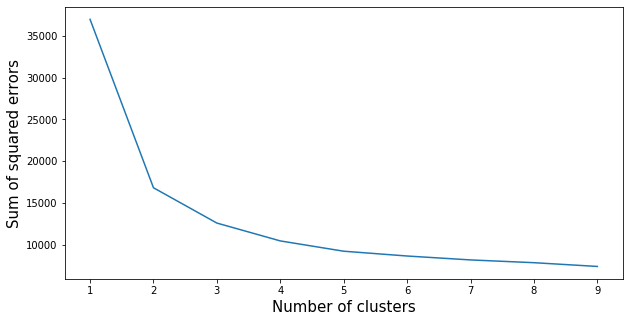

In [504]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

iterations = 10

sum_of_squares = []
clusters = range(1,10)

for n in clusters:
    k_means = KMeans(init = 'k-means++', n_clusters = n, n_init = iterations)
    k_means.fit(df4.iloc[:,1:])
    sum_of_squares.append(k_means.inertia_)
    
plt.figure(figsize = (10,5))
plt.plot(clusters, sum_of_squares)
plt.xlabel('Number of clusters', fontsize = 15)
plt.ylabel('Sum of squared errors', fontsize = 15)
plt.show()

The above graph of sum of squared differences suggests that 3, 4 or 5 clusters are optimal in this case. We use 4 clusters for the rest of the analysis.

We use the KMeans algorithm to cluster the data into 4 clusters.

In [510]:
k_means = KMeans(init = 'k-means++', n_clusters = 4, n_init = 20)
k_means.fit(df4.iloc[:,1:])
df4['Cluster'] = k_means.labels_
df4['Cluster'].value_counts()

C:\Users\kitfitton\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    368
3    121
1     69
2     34
Name: Cluster, dtype: int64

We can examine the different clusters and understand their properties

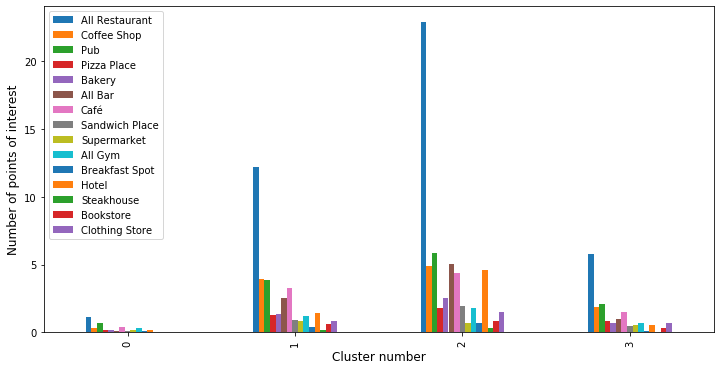

In [513]:
df4.groupby(by = 'Cluster').mean().plot(kind = 'bar', figsize = (12,6))
plt.legend(loc = 'upper left')
plt.ylabel('Number of points of interest', fontsize = 12)
plt.xlabel('Cluster number', fontsize = 12)
plt.show()

It appears that the clusters have largely been created based on the total number of points of interest in each neighbourhood.

We can add the cluster information to the main datafram to create a final dataframe containing all the information needed from our analysis.

In [470]:
final_df = df.merge(df4['Cluster'], right_index = True, left_index = True)
final_df

,Ward name,Borough name,Median house price,lat,lng,Cluster
E05000026,Abbey,Barking and Dagenham,220.0,51.5356876,0.07553043645175103,2
E05000027,Alibon,Barking and Dagenham,310.0,51.5482797,0.153244,2
E05000028,Becontree,Barking and Dagenham,307.5,51.5403111,0.1265241,2
E05000029,Chadwell Heath,Barking and Dagenham,359.0,51.5679857,0.127994,2
E05000030,Eastbrook,Barking and Dagenham,338.0,51.5515648,0.16154306778846314,2
...,...,...,...,...,...,...
E05000645,Tachbrook,Westminster,677.5,51.4933046,-0.1400497,1
E05000646,Vincent Square,Westminster,740.0,51.4940178,-0.1362304,1
E05000647,Warwick,Westminster,780.0,51.49240735,-0.13970480261141285,1
E05000649,West End,Westminster,1300.0,51.5090757,-0.1297453,0


To visualise the clustering, we can plot the different clusters in different colours on a map of London.

In [514]:
colours = ['red', 'green','blue','yellow']

map3 = folium.Map(location = [london_lat, london_lng], zoom_start = 10)

for name, lat, lng, cluster in zip(final_df['Ward name'], final_df['lat'], final_df['lng'], final_df['Cluster']):
    label = name
    folium.CircleMarker(location = [lat, lng],
                       radius = 4,
                       icon = None,
                       color = colours[cluster],
                        fill=True,
                        fill_color=colours[cluster],
                        fill_opacity=1,
                        popup = label
                       ).add_to(map3)

map3

It appears that there is a geographical component to the clusters. This makes sense as neighbourhoods further from the centre of London are more likely to be residential and have fewer points of interest.

We will now consider only the neighbourhoods that are most similar to our preferred neighbourhood, in this case Balham.

Since we're interested in house prices, we will plot median house price for each of these clusters.

C:\Users\kitfitton\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


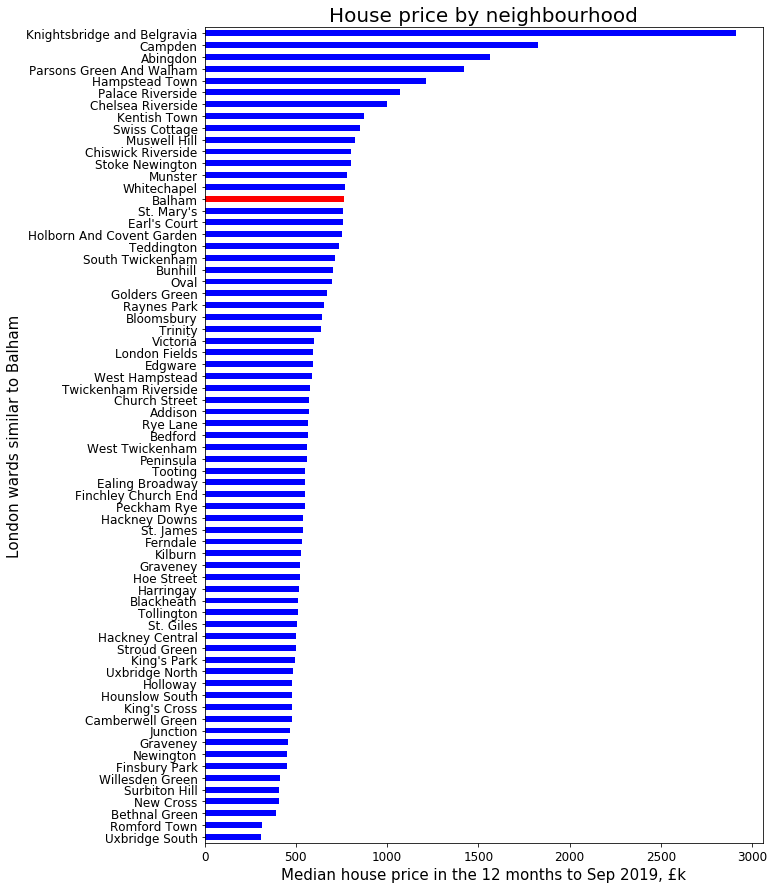

In [522]:
preferred_neighbourhood = 'Balham'

similar_df = final_df[final_df['Cluster'] == int(final_df[final_df['Ward name'] == preferred_neighbourhood]['Cluster'])]
similar_df.sort_values(by = 'Median house price', ascending = True, inplace = True)

colour = []

for ward in similar_df['Ward name']:
    if ward == preferred_neighbourhood:
        c = 'red'
    else:
        c = 'blue'

    colour.append(c)

similar_df.plot('Ward name', 'Median house price', 
                kind = 'barh',
                color = colour,
                figsize = (10,15),
                fontsize = 12,
                legend = None
                )

plt.title('House price by neighbourhood', fontsize = 20)
plt.xlabel('Median house price in the 12 months to Sep 2019, £k', fontsize = 15)
plt.ylabel('London wards similar to ' + preferred_neighbourhood, fontsize = 15)

plt.show()

From this we can see there are plent of neighbourhoods worth considering that are similar to Balham but where house prices are lower.

In [531]:
suitable_df = similar_df[similar_df['Median house price'] < int(similar_df[similar_df['Ward name'] == preferred_neighbourhood]['Median house price'])]
print('Number of neighbourhoods worth considering = '+str(suitable_df.shape[0]))

Number of neighbourhoods worth considering = 54


## 4. Results

Our analysis has considered the ~600 neighbourhoods within London. Based on information about the preferences of a hypothetical family, we have come up with a 'longlist' of 54 neighbourhoods that might be of interest to this family. These neighbourhoods are most similar to the neighbourhood where the family currently lives in terms of their amenities and points of interest. These neighbourhoods are also more affordable than where they live currently.

54 neighbourhoods is still a lot to consider, so we may want to identify ways to prioritise them. There are a number of ways we could do this and we consider two below to refine our results further.

#### Prioritising neighbourhoods close to Balham

One way to do this is to prioritise neighbourhoods that are close to the current preferred neighbourhoods, in order to limit the disruption of moving away from friends and family. To help prioritise neighbourhoods we can start by focussing on those within a 5km radius of Balham, as depicted in the following map.

In [533]:
search_radius = 5000

map4 = folium.Map(location = [final_df[final_df['Ward name'] == preferred_neighbourhood]['lat'],final_df[final_df['Ward name'] == preferred_neighbourhood]['lng']], zoom_start = 12)

for name, lat, lng in zip(suitable_df['Ward name'], suitable_df['lat'], suitable_df['lng']):
    label = name
    folium.CircleMarker(location = [lat, lng],
                       radius = 4,
                       icon = None,
                       color = 'blue',
                        fill=True,
                        fill_color='blue',
                        fill_opacity=1,
                        popup = label
                       ).add_to(map4)
    
folium.Circle(location = [final_df[final_df['Ward name'] == preferred_neighbourhood]['lat'], 
                               final_df[final_df['Ward name'] == preferred_neighbourhood]['lng']],
                   radius = search_radius,
                   icon = None,
                   color = 'red',
                   fill = False
                   ).add_to(map4)

map4

#### Prioritising neighbourhoods based on specific amenities

An alternative way to prioritise neighbourhoods would be to pick a specific amenity or point of interest that is essential to live close to. For example, our hypothetical family may choose to only look at neighbourhoods that contain a beer store.

In [537]:
poi = 'Beer Store'

df3[(df3[poi] > 0) & df3['Ward name'].isin(suitable_df['Ward name'])]['Ward name']

E05000371    Finsbury Park
E05000611          Bedford
E05000626          Tooting
Name: Ward name, dtype: object

This would give our family a prioritised list of neighbourhoods to consider looking at in order to buy our home.

Two of these neighbourhoods (Bedford and Tooting) also happen to fall within a 5km radius of Balham, so may be worth considering first.

## 5. Conclusion

The purpose of this project was to help a hypothetical family identity a neighbourhood in London in which they could buy their first home. The only information we had about the family's preference was that they liked their current neighbourhood but could not afford a home there.

By understanding the amenities and therefore 'feel' of each London neighbourhood and using K-Means clustering, we came up with a list of neighbourhoods that the family are likely to enjoy living in based on the fact that they are similar to their current neighbourhood. We further refined this list be only considering neighbourhoods where houses are cheaper than the family's current neighbourhood.

The list of neighbourhoods should be used as a starting point for final exploration by the family. We also suggested a couple of ways that the family could narrow the list even further.

The final decision on optimalneighbourhood will be made by the family based on specific characteristics of the neighbourhood and house prices, taking into consideration additional factors like transport connections, levels of crime, social and economic dynamics of every neighborhood etc.